In [2]:
import os
from os.path import join
import chess.pgn
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
from requests_html import HTMLSession
from joblib import Parallel, delayed
from tqdm import tqdm
from irl_chess.misc_utils.utils import union_dicts
from irl_chess.chess_utils.sunfish_utils import board2sunfish, eval_pos, sunfish_move_to_str, str_to_sunfish_move
from irl_chess.chess_utils.sunfish import piece, pst
from irl_chess.models.sunfish_GRW import sunfish_move
from collections import defaultdict
from irl_chess.misc_utils.load_save_utils import fix_cwd, load_config, get_board_after_n, get_states

[D:matplotlib] matplotlib data path: %s
[D:matplotlib] CONFIGDIR=%s
[D:matplotlib] interactive is %s
[D:matplotlib] platform is %s
[D:matplotlib] CACHEDIR=%s
[D:matplotlib.font_manager] Using fontManager instance from %s


In [6]:
!pip install selenium

  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.5 MB 960.0 kB/s eta 0:00:11
   ---------------------------------------- 0.1/10.5 MB 1.3 MB/s eta 0:00:09
    --------------------------------------- 0.2/10.5 MB 1.3 MB/s eta 0:00:08
    --------------------------------------- 0.2/10.5 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.3/10.5 MB 1.4 MB/s eta 0:00:08
   - -------------------------------------- 0.4/10.5 MB 1.3 MB/s eta 0:00:08
   - -------------------------------------- 0.5/10.5 MB 1.5 MB/s eta 0:00:07
   -- ------------------------------------- 0.5/10.5 MB 1.5 MB/s eta 0:00:07
   -- ------------------------------------- 0.6/10.5 MB 1.6 MB/s eta 0:00:07
   -- ------------------------------------- 0.7/10.5 MB 1.6 MB/s eta 0:00:07
   --- ------------------------------------ 0.8/10.5 MB 1.6 MB/s eta 0:00:06
   --- -------------

In [2]:
def top_k_moves(move_dict, k, verbose=False):
    score_matrix = np.zeros((len(move_dict), 200), dtype=float) - np.inf
    for i, (move, scores) in enumerate(move_dict.items()):
        score_matrix[i, :len(scores)] = scores
    moves_at_depth = (score_matrix != -np.inf).sum(axis=0)
    top_moves_depth = sum(moves_at_depth > k)
    top_moves_idxs = np.where(score_matrix[:, top_moves_depth] != -np.inf)[0]
    if verbose:
        print('Intermediary moves')
        print({sunfish_move_to_str(move) for i, move in enumerate(move_dict) if i in top_moves_idxs}, '\n')
    score_matrix[top_moves_idxs, top_moves_depth-1] = -np.inf
    missing_moves = k - len(top_moves_idxs)
    if verbose:
        print(missing_moves)
    if missing_moves:
        top_moves_idxs = np.append(top_moves_idxs, score_matrix[:, top_moves_depth-1].argsort()[-missing_moves:])
    return {sunfish_move_to_str(move) for i, move in enumerate(move_dict) if i in top_moves_idxs}

In [13]:
pgn = open("data/raw/lichess_db_standard_rated_2013-01.pgn")
failures = 0
for i in tqdm(range(100)):
    game = chess.pgn.read_game(pgn)
    board = game.board()
    state, player_move = get_board_after_n(game, 15)
    sf_state = board2sunfish(state, 300)
    if not state.turn:
        state = state.transform(chess.flip_horizontal)
        state.apply_mirror()
    player_move = sunfish_move_to_str(player_move)
    move, best_moves, move_dict = sunfish_move(sf_state, pst, 0.5, move_only=False)
    best_moves = {sunfish_move_to_str(move) for move in best_moves.keys()}
    top_moves = top_k_moves(move_dict, len(best_moves))
    if not top_moves == best_moves:
        print('Failure')
        failures += 1
print(f'{failures}/100')

  4%|▍         | 4/100 [00:04<01:39,  1.04s/it]

Failure


  7%|▋         | 7/100 [00:07<01:38,  1.06s/it]

Failure


  9%|▉         | 9/100 [00:08<01:26,  1.05it/s]

Failure


 25%|██▌       | 25/100 [00:20<00:55,  1.35it/s]

Failure


 35%|███▌      | 35/100 [00:31<00:55,  1.17it/s]

Failure


 47%|████▋     | 47/100 [00:41<00:40,  1.31it/s]

Failure


 53%|█████▎    | 53/100 [00:45<00:30,  1.53it/s]

Failure


 58%|█████▊    | 58/100 [00:51<00:56,  1.35s/it]

Failure


 74%|███████▍  | 74/100 [01:05<00:18,  1.40it/s]

Failure


 77%|███████▋  | 77/100 [01:07<00:17,  1.30it/s]

Failure


 86%|████████▌ | 86/100 [01:14<00:13,  1.04it/s]

Failure


 99%|█████████▉| 99/100 [01:28<00:01,  1.13s/it]

Failure


100%|██████████| 100/100 [01:29<00:00,  1.11it/s]

12/100


Sunfish best move: a1a7
Sunfish moves: {'d3d4', 'a1a7', 'e4d5', 'd1b1', 'c3d5'}
Player move: e4d5


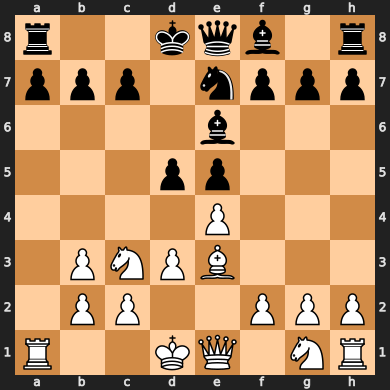

In [4]:
move, best_moves, move_dict = sunfish_move(sf_state, pst, time_limit=200, max_depth=3, move_only=False)
print(f'Sunfish best move: {sunfish_move_to_str(move)}')
print(f'Sunfish moves: {top_k_moves(move_dict, 5)}')
print(f'Player move: {player_move}')

state

In [49]:
pgn = open("data/raw/lichess_db_standard_rated_2013-01.pgn")
failures = 0
depths = [1,2,3,4,5,6]
depth_scores = [0] * len(depths)
for i in tqdm(range(100), desc='Iterating through states'):
    game = chess.pgn.read_game(pgn)
    board = game.board()
    state, player_move = get_board_after_n(game, 15)
    sf_state = board2sunfish(state, 300)
    player_move = sunfish_move_to_str(player_move)
    for i, depth in enumerate(depths):
        move, best_moves, move_dict = sunfish_move(sf_state, pst, time_limit=200, max_depth=depth, move_only=False)
        top_5_moves = top_k_moves(move_dict, 5)
        depth_scores[i] += player_move in top_5_moves
print(depth_scores)

Iterating through states:   0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [3]:
with open('experiment_configs\\depths\\config_lower.json', 'r') as file:
    config_lower = json.load(file)
print(config_lower)
    
with open('experiment_configs\\depths\\config_upper.json', 'r') as file:
    config_upper = json.load(file)

{'time_limit': 200, 'R_true': [100, 280, 320, 479, 929, 60000], 'overwrite': False, 'n_files': 3, 'min_elo': 800, 'max_elo': 1200, 'n_midgame': 15, 'n_endgame': 30, 'n_boards': 500, 'n_threads': -2, 'move_function': 'player_move'}


In [4]:
websites_filepath = join(os.getcwd(), 'downloads', 'lichess_websites.txt')
file_path_data = join(os.getcwd(), 'data', 'raw')

sunfish_boards_lower, player_moves_lower = get_states(websites_filepath=websites_filepath,
                                                        file_path_data=file_path_data,
                                                        config_data=config_lower)
player_moves_lower = [sunfish_move_to_str(move) for move in player_moves_lower]

sunfish_boards_upper, player_moves_upper = get_states(websites_filepath=websites_filepath,
                                                        file_path_data=file_path_data,
                                                        config_data=config_upper)
player_moves_upper = [sunfish_move_to_str(move) for move in player_moves_upper]



-------------------  1/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  2/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  3/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total
C:\Users\nikol\Documents\GitHub\irl-chess\data\raw\lichess_db_standard_rated_2013-01.pgn


Looking through file 0: 100%|██████████| 92811021/92811021 [06:56<00:00, 222631.48it/s]


C:\Users\nikol\Documents\GitHub\irl-chess\data\raw\lichess_db_standard_rated_2014-01.pgn


Looking through file 1:   0%|          | 791075/574506567 [00:03<38:09, 250590.21it/s]




-------------------  1/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  2/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total


-------------------  3/12  -------------------


Time taken: 0.00 seconds for file
Time taken: 0.00 seconds in total
C:\Users\nikol\Documents\GitHub\irl-chess\data\raw\lichess_db_standard_rated_2013-01.pgn


Looking through file 0:   2%|▏         | 1910307/92811021 [00:08<06:31, 232426.08it/s]


In [41]:
pgn = open("data/raw/lichess_db_standard_rated_2014-01.pgn")
elos = []
for i in tqdm(range(5000), desc='Iterating through states'):
    game = chess.pgn.read_game(pgn)
    try:
        elos.append(int(game.headers['WhiteElo']))
    except ValueError:
        continue
elos = np.array(elos)

Iterating through states: 100%|██████████| 5000/5000 [00:14<00:00, 342.54it/s]


In [42]:
sum(elos<1000)

2

In [6]:
len(player_moves_upper)

500

In [10]:
def correct_at_depth(player_move, state, depth):
    move, best_moves, move_dict = sunfish_move(state, pst, time_limit=200, max_depth=depth, move_only=False)
    #top_5_moves = top_k_moves(move_dict, 5)
    return player_move == sunfish_move_to_str(move)

n_threads = config_lower['n_threads']
n_boards = config_lower['n_boards']
with Parallel(n_jobs=n_threads) as parallel:
    depths = [1,2,3,4,5]
    depth_scores_lower = [0] * len(depths)
    depth_scores_upper = [0] * len(depths)
    for i, depth in enumerate(depths):
        print(f'\n Depth: {depth} \n', '-'*20)
        correct_lower = parallel(delayed(correct_at_depth)(player_move, state, depth)
                                 for player_move, state in tqdm(list(zip(player_moves_lower, sunfish_boards_lower))))
        correct_upper = parallel(delayed(correct_at_depth)(player_move, state, depth)
                                 for player_move, state in tqdm(list(zip(player_moves_upper, sunfish_boards_upper))))
        depth_scores_lower[i] = sum(correct_lower)/n_boards
        depth_scores_upper[i] = sum(correct_upper)/n_boards
lower_min_elo = config_lower['min_elo']
lower_max_elo = config_lower['max_elo']
upper_min_elo = config_upper['min_elo']
upper_max_elo = config_upper['max_elo']
print(f'Depth scores for ELO {lower_min_elo}-{lower_max_elo}: {depth_scores_lower}')
print(f'Depth scores for ELO {upper_min_elo}-{upper_max_elo}: {depth_scores_upper}')


 Depth: 1 
 --------------------


100%|██████████| 500/500 [00:02<00:00, 175.86it/s]



 Depth: 2 
 --------------------


100%|██████████| 500/500 [00:20<00:00, 24.29it/s]



 Depth: 3 
 --------------------


100%|██████████| 500/500 [00:52<00:00,  9.56it/s]



 Depth: 4 
 --------------------


100%|██████████| 500/500 [03:39<00:00,  2.27it/s]



 Depth: 5 
 --------------------


100%|██████████| 500/500 [09:45<00:00,  1.17s/it]


Depth scores for ELO 800-1200: [0.312, 0.3, 0.314, 0.312, 0.31]
Depth scores for ELO 1600-1800: [0.318, 0.32, 0.336, 0.344, 0.336]


In [3]:
pgn = open("data/raw/lichess_db_standard_rated_2013-01.pgn")
for i in tqdm(range(100), desc='Iterating through states'):
    game = chess.pgn.read_game(pgn)
    board = game.board()
    state, player_move = get_board_after_n(game, 3)

Iterating through states: 100%|██████████| 100/100 [00:00<00:00, 348.67it/s]


In [5]:
from requests_html import AsyncHTMLSession
import nest_asyncio
import os

os.environ['PYPPETEER_CHROMIUM_REVISION'] = '1263111'

nest_asyncio.apply()

site = 'https://lichess.org/analysis/standard/'
fen = state.fen()
url = site + fen

asession = AsyncHTMLSession()
r = await asession.get(url)
await r.html.arender()
resp=r.html.raw_html
r.html.render()
soup = BeautifulSoup(r.content)


[D:urllib3.connectionpool] Starting new HTTPS connection (%d): %s:%s
[D:urllib3.connectionpool] %s://%s:%s "%s %s %s" %s %s
[D:websockets.client] = connection is CONNECTING
[D:websockets.client] > GET %s HTTP/1.1
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] > %s: %s
[D:websockets.client] < HTTP/1.1 %d %s
[D:websockets.client] < %s: %s
[D:websockets.client] < %s: %s
[D:websockets.client] < %s: %s
[D:websockets.client] < %s: %s
[D:websockets.client] = connection is OPEN
[D:websockets.client] > %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] > %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] > %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets.client] < %s
[D:websockets

RuntimeError: Cannot use HTMLSession within an existing event loop. Use AsyncHTMLSession instead.

In [23]:
!pip install pyppeteer==1.0.0

   ---------------------------------------- 0.0/83.5 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/83.5 kB ? eta -:--:--
   ------------------- -------------------- 41.0/83.5 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 83.5/83.5 kB 671.7 kB/s eta 0:00:00
  Attempting uninstall: pyee
    Found existing installation: pyee 11.1.0
    Uninstalling pyee-11.1.0:
      Successfully uninstalled pyee-11.1.0
  Attempting uninstall: pyppeteer
    Found existing installation: pyppeteer 2.0.0
    Uninstalling pyppeteer-2.0.0:
      Successfully uninstalled pyppeteer-2.0.0
